In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import plotly.graph_objects as gr

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
# Правая часть уравнения теплопроводности
def f(x, t):
    return (-3) * (1 + np.cosh(1 - x - t)**2 + np.sinh(2 - 2*x - 2*t)) / (8 * np.cosh(1 - x - t)**(3/2))

# Функкция начального условия
def phi(x):
    return 3 / 2 * np.cosh(1 - x)**(1/2)

# Граничные условия
A1 = 0
B1 = 1
C1 = lambda t: 3 / 2 * (np.cosh(1 - t))**(1/2)

A2 = -2
B2 = 1
C2 = lambda t: 3 / 2 * (np.cosh(t) - np.sinh(t)) / np.cosh(t)**(1/2)

# Параметр a уравнения
a = 1

# Настоящее решение уравнения
def solution(x, t):
    return 3 / 2 * np.cosh(1 - x - t)**(1/2)

Зададим параметры пространственно-временной сетки:

In [4]:
h = 0.05
l = 1
N = int(l / h)+1
X = np.linspace(0, l, num=N)

t = 1
dt = 0.05

M = int(t / dt) + 1
T = np.linspace(0, t, num=M)

# Задаём сигму
sigma = 0.5

Напишем алгоритм решения системы уравнений с тридиагональной матрицей:

In [5]:
def TridiagMatrixMethod(m, u, l=l, A1=A1, B1=B1, C1=C1, A2=A2, B2=B2, C2=C2, sigma=sigma, h=h, N=N, dt=dt, X=X, T=T, f=f, order=1, type="3D"):
    
    # Функция "прямого хода" по матрице
    def forward_path(A, B, C, D, n=N-1):
        AA = [-C[0]  / B[0]]
        BB = [D[0] / B[0]]
        for i in range(1, n):
            AA.append(- C[i] / (B[i] + A[i] * AA[i-1]))
            BB.append((D[i] - A[i]*BB[i-1]) / (B[i] + A[i] * AA[i-1]))
        return AA, BB

    # Функция "обратного хода" по матрице
    def backward_path(AA, BB, n=N-1):
        Y = []
        Y.append(BB[n-1])
        for i in range(n - 2, -1, -1):
            Y.append(BB[i] + AA[i] * Y[n - i - 2])
        return Y[::-1]
    
    X = np.linspace(0, l, N)
    
    cur = a * a * dt / h / h

    A = [0]
    B = [0]
    C = [0]
    D = [0]
    
    for i in range(1, N - 1):
        A.append(cur * sigma)
        B.append((-2) * cur * sigma - 1)
        C.append(cur * sigma)
        if type=="3D":
            D.append(-u[m][i] - dt*f(X[i], T[m] + dt / 2) + (sigma - 1) * a * a * dt / h / h * (u[m][i+1] - 2 * u[m][i] + u[m][i-1]))
        elif type=="2D":
            D.append(-u[i] - dt*f(X[i], T[m] + dt / 2) + (sigma - 1) * a * a * dt / h / h * (u[i+1] - 2 * u[i] + u[i-1]))
        else:
            raise ValueError("Incorrect order of algorithm (avail.: 1, 2)")

    if order == 1:
        A[0] = (0)
        B[0] = (-A1 / h + B1)
        C[0] = (A1 / h)
        D[0] = (C1(T[m+1]))

        A.append(-A2 / h)
        B.append(A2 / h + B2)
        C.append(0)
        D.append(C2(T[m+1]))
    
    elif order == 2:
        
        A[0] = (0)
        B[0] = (A1 - h*B1 + A1 / (2*cur*sigma))
        C[0] = (-A1)
        A.append((A2))
        B.append(-(A2 + h*B2 + A2/(2*cur*sigma)))
        C.append(0)
        if type=="3D":
            D[0] = (-h*C1(T[m+1]) + A1 / (2*cur*sigma)*(u[m][0] + dt*f(X[0],T[m]+dt/2)) + (sigma-1)/sigma*((A1-h*B1)*u[m][0] - A1*u[m][1] + h*C1(T[m])))
            D.append(((-h*C2(T[m+1]) - A2/(2*cur*sigma)*(u[m][-1] + dt*f(X[-1],T[m]+dt/2)) - (sigma-1)/sigma*((A2+h*B2)*u[m][-1] - A2*u[m][-2] - h*C2(T[m])))))
        elif type=="2D":
            D[0] = (-h*C1(T[m+1]) + A1 / (2*cur*sigma)*(u[0] + dt*f(X[0],T[m]+dt/2)) + (sigma-1)/sigma*((A1-h*B1)*u[0] - A1*u[1] + h*C1(T[m])))
            D.append(((-h*C2(T[m+1]) - A2/(2*cur*sigma)*(u[-1] + dt*f(X[-1],T[m]+dt/2)) - (sigma-1)/sigma*((A2+h*B2)*u[-1] - A2*u[-2] - h*C2(T[m])))))
        else:
            raise ValueError("Incorrect order of algorithm (avail.: 1, 2)")
    else:
        raise ValueError("Incorrect order of algorithm (avail.: 1, 2)")

    AA, BB = forward_path(A, B, C, D, N)
    Y = backward_path(AA, BB, N)

    return Y

Построим решения нашей задачи на основе вышеизложенной теории:

In [6]:
def solver_h(X=X, T=T, order=1):
    N = len(X)
    M = len(T)
    u = np.zeros(shape=(M, N))
    u[0] = [phi(x) for x in X]
    for i in range(1, M):
        u[i] = TridiagMatrixMethod(m=i-1, u=u, X=X, T=T, N=N, order=order)
    return u

Сделаем визуализацию решения:

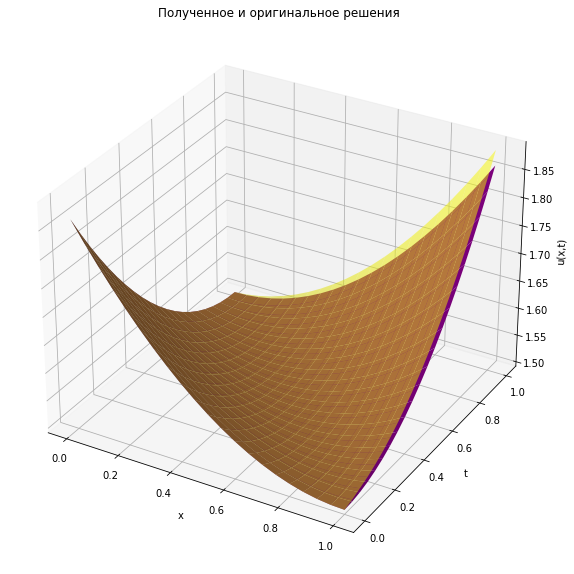

In [7]:
%matplotlib inline
def plot_u(X=X, T=T, order=1):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(projection='3d')

  Xs, Ts = np.meshgrid(X, T)
  u = solver_h(order=order)

  ax.set_xlabel('x')
  ax.set_ylabel('t')
  ax.set_zlabel('u(x,t)')
  ax.title.set_text("Полученное и оригинальное решения")
  
  ax.plot_surface(Xs, Ts, solution(Xs, Ts), color="purple", alpha=1, label="Real")
  ax.plot_surface(Xs, Ts, u, color="yellow", alpha=0.5, label="Calc")

plot_u(order=1)

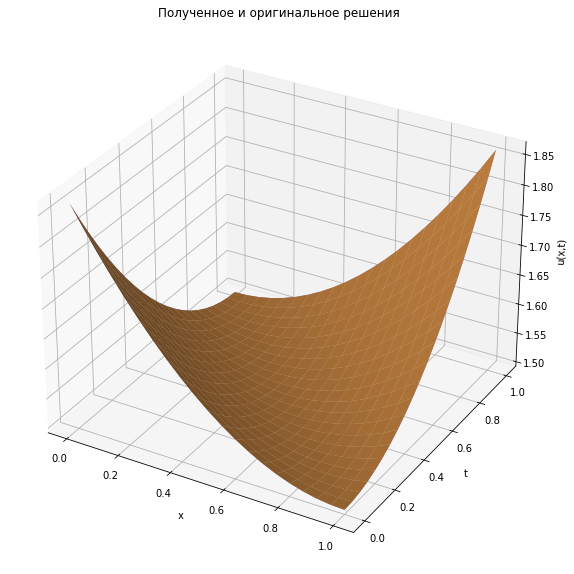

In [8]:
plot_u(order=2)

Оценим ошибки полученного решения:

Максимальная ошибка для данных $h$ и $\tau$:

In [12]:
def max_error(X=X, T=T, order=1):
    Xs, Ts = np.meshgrid(X, T)
    return np.max(np.abs(solution(Xs, Ts) - solver_h(X=X, T=T, order=order)))

In [13]:
print(f"Order 1 max error: {max_error(X=X, T=T, order=1)}")
print(f"Order 2 max error: {max_error(X=X, T=T, order=2)}")

Order 1 max error: 0.027098099575947554
Order 2 max error: 3.194013625362757e-05


Далее приведена реализация построения 2D графиков на основе предыдущего слоя.

In [16]:
def solver_h_2D(n=1, X=X, T=T, order=1):
    N = len(X)
    u = [phi(x) for x in X]
    for i in range(1, n):
        u = TridiagMatrixMethod(m=i-1, u=u, X=X, T=T, N=N, order=order, type="2D")
    return u

def plot_2D(m=1, order=1):
    global X
    global T

    plt.clf()
    ax = plt.gca()
    ax.set_xlim([-h, l+h])
    ax.set_ylim([0, 2])
    
    u = solver_h_2D(n=m, order=order)
    real_u = [solution(x, T[m-1]) for x in X]

    plt.plot(X, u, label="Numerical Solution")
    plt.plot(X, real_u, label="Real Solution")

    plt.grid(True)
    plt.legend()
    try:
        plt.savefig(f"./graphs/t ={T[m-1]: .2f}, order = {order}.jpg")
    except Exception:
        print("An error occured while saving graph to /graph directory. Check if it's created.")
        
    plt.show() 
    

In [17]:
interact(plot_2D, m=(1, len(T), 1), order=(1, 2, 1))

interactive(children=(IntSlider(value=1, description='m', max=21, min=1), IntSlider(value=1, description='orde…

<function __main__.plot_2D(m=1, order=1)>